In [15]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# from sod.core.evaluation import normalize
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot
isoutl = sod_core_dataset.is_outlier

print('Allset train')
allset_train = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)
print(sod_core_dataset.dfinfo(allset_train))

print()
print()
print('Allset test')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print(sod_core_dataset.dfinfo(allset_test))

Allset train

ok (1295742 instances)
                          Min      Median           Max    #NAs  #<1Perc.  #>99Perc.
psd@0.05sec     -1.982674e+02 -121.027945    -18.616519  524709      7711       7711
psd@0.1sec      -2.078356e+02 -123.752472    -18.540183       0     12958      12958
psd@0.2sec      -2.009926e+02 -125.509055    -18.394193       1     12958      12958
psd@0.5sec      -2.473580e+02 -127.511828    -17.799973       4     12958      12958
psd@1sec        -2.434902e+02 -124.856119    -17.364621      10     12958      12958
psd@2sec        -2.435557e+02 -121.563437    -14.675753      21     12958      12958
psd@3sec        -2.383163e+02 -121.112254     -7.249915      54     12957      12957
psd@5sec        -2.334575e+02 -122.870636      7.845090      56     12957      12957
psd@9sec        -2.316435e+02 -131.279169     19.164349   25553     12702      12701
amplitude_ratio  4.768372e-07    0.001118     36.623112       0     12899      12958
magnitude        9.000000e-0

In [54]:
print(sod_core_dataset.dataset_info(allset_train).uid_columns)
print(sod_core_dataset.dataset_info(allset_test).uid_columns)

print(allset_train.columns)
print(allset_test.columns)


import matplotlib.pyplot as plt
from contextlib import contextmanager

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

('allset_train.id', 'allset.id', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier')
('allset_test.id', 'allset.id', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier')
Index(['allset_train.id', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec',
       'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec',
       'psd@5sec', 'psd@9sec', 'outlier', 'subclass', 'window_type',
       'amplitude_ratio', 'event_id', 'station_id', 'event_time',
       'channel_code', 'magnitude', 'distance_km', 'location_code'],
      dtype='object')
Index(['allset_test.id', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec',
       'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec',
       'psd@5sec', 'psd@9sec', 'outlier', 'subclass', 'window_type',
       'amplitude_ratio', 'event_id', 'station_id', 'event_time',
       'channel_code', 'magnitude', 'distance_km', 'location_code'],
      dtype='object')



Allset train


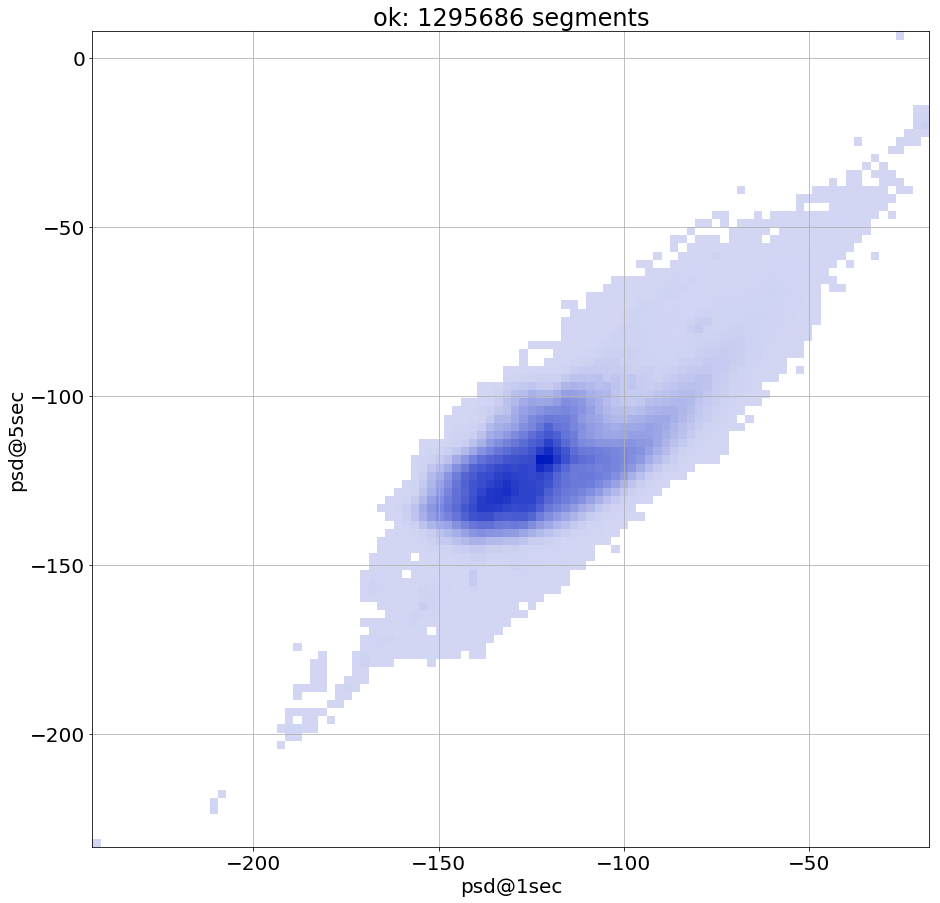

In [17]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)


print()
print('Allset train')
%matplotlib inline
with plotparams({'figure.figsize': (15, 15), 'font.size': 20}):
    fig = sod_plot.plot(allset_train, 'psd@1sec', 'psd@5sec', axis_lim=None)


Allset test


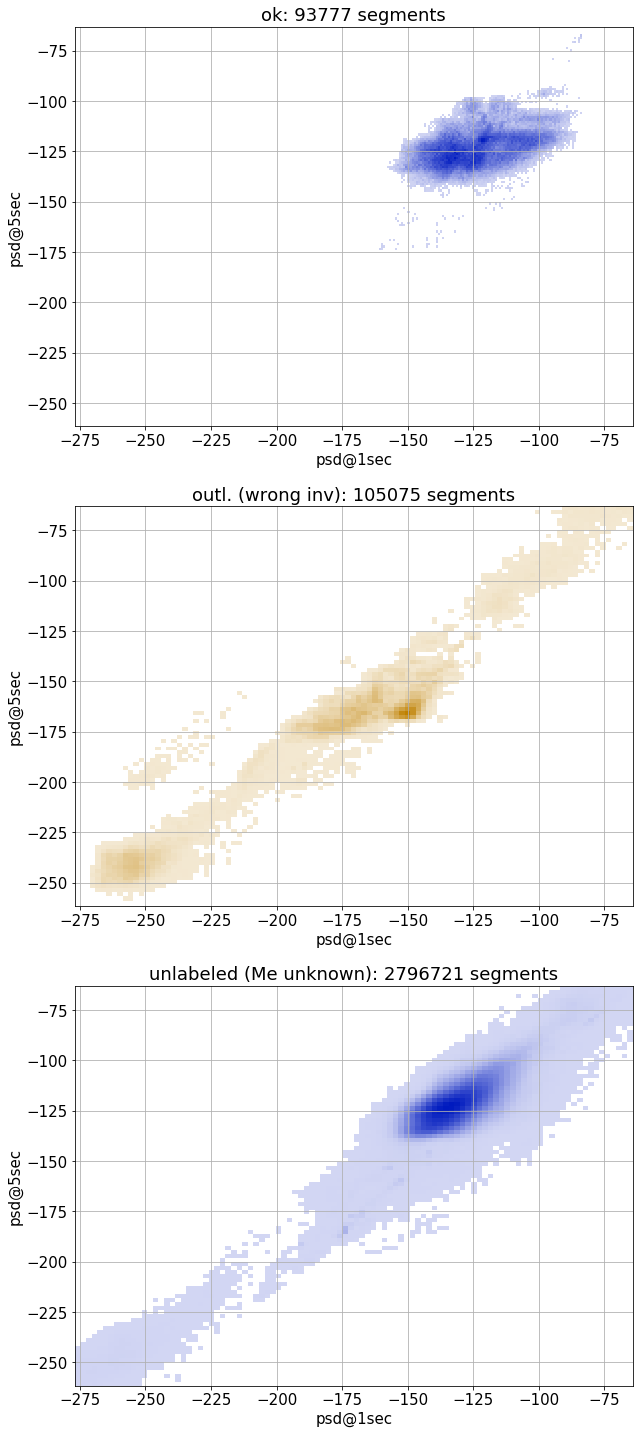

In [37]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print()
print('Allset test')
with plotparams({'figure.figsize': (10, 25), 'font.size': 15}):
    fig = sod_plot.plot(allset_test, 'psd@1sec', 'psd@5sec', axis_lim=.994)

In [30]:
# Splitting train and test:
print('Splitting train and test')

cols = ['dataset_id', 'subclass', 'window_type', 'outlier', 'num_segments']

print('\nTrain (all inliers): %d segments' % len(allset_train))
print()
printdfr = []
for _, df_ in allset_train.groupby(cols[:-1]):
    printdfr.append({**{cols[i]: _[i] for i in range(len(cols)-1)}, **{cols[-1]: len(df_)}})
print(pd.DataFrame(printdfr, columns=cols).to_string(index=False))

print('\nTest (others): %d segments' % len(allset_test))
print()
printdfr = []
for _, df_ in allset_test.groupby(cols[:-1]):
    printdfr.append({**{cols[i]: _[i] for i in range(len(cols)-1)}, **{cols[-1]: len(df_)}})
print(pd.DataFrame(printdfr, columns=cols).to_string(index=False))


Splitting train and test

Train (all inliers): 1295742 segments

dataset_id subclass window_type  outlier  num_segments
         1                    n    False        307319
         1                    s    False        307316
         2                         False        582997
         3                         False         98110

Test (others): 2997672 segments

dataset_id                                  subclass window_type  outlier  num_segments
         1                                                     a     True         11389
         1                                                     n    False         21387
         1                                                     s    False         21391
         1  INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml           n     True             3
         1  INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml           s     True             3
         1  INVFILE:CH.GRIMS.2015-10-30T10:50:00.xml           n     True           747
         1

In [33]:
for c in allset_train.columns:
    print(c + ': ' + str(allset_train[c].dtype))

allset_train.id: int64
dataset_id: int64
psd@0.05sec: float64
psd@0.1sec: float64
psd@0.2sec: float64
psd@0.5sec: float64
psd@1sec: float64
psd@2sec: float64
psd@3sec: float64
psd@5sec: float64
psd@9sec: float64
outlier: bool
subclass: category
window_type: category
amplitude_ratio: float64
event_id: int64
station_id: int64
event_time: datetime64[ns]
channel_code: category
magnitude: float64
distance_km: float64
location_code: category


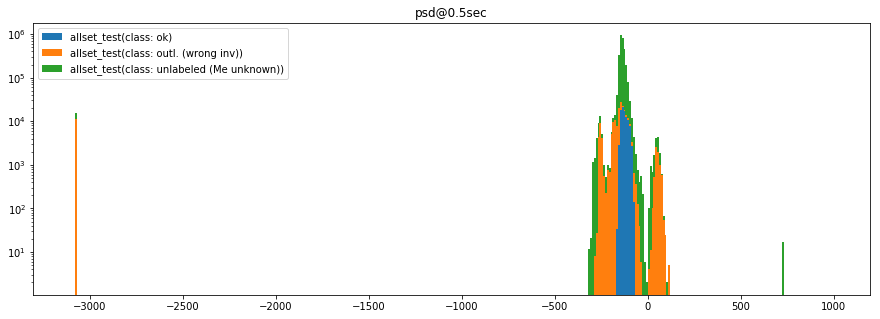

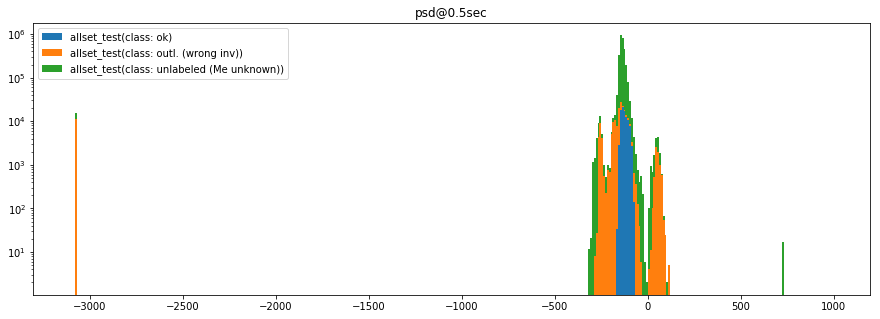

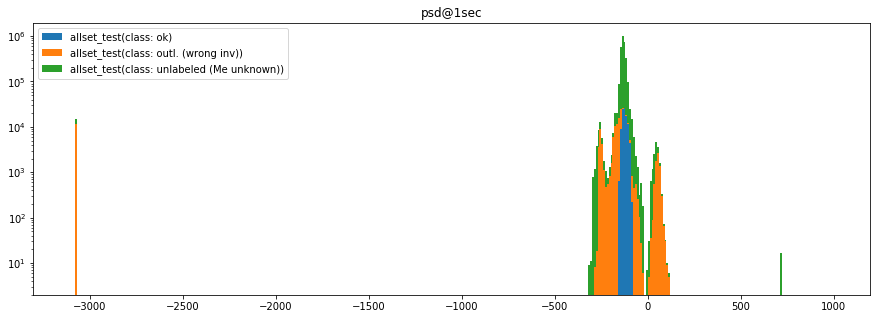

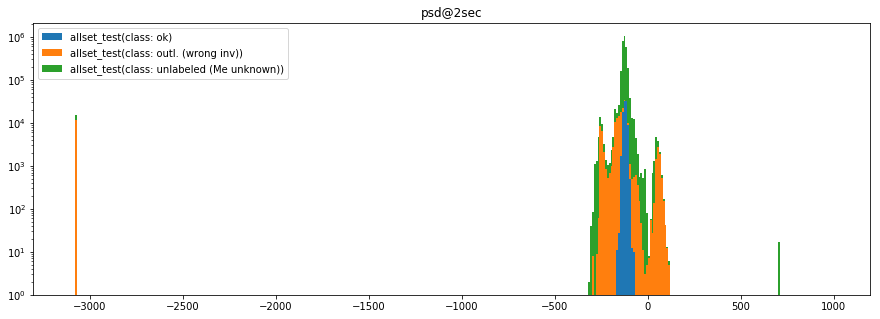

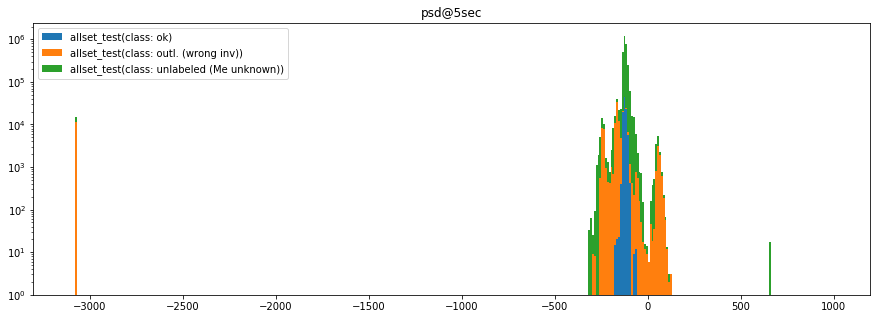

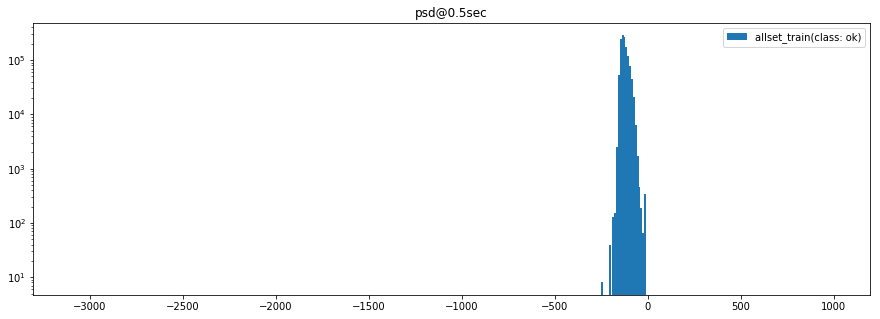

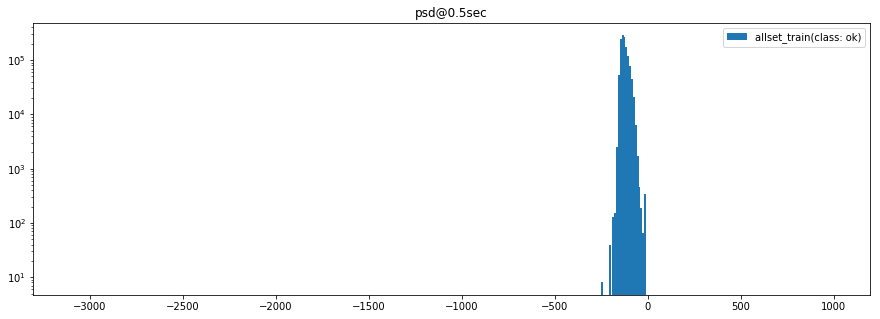

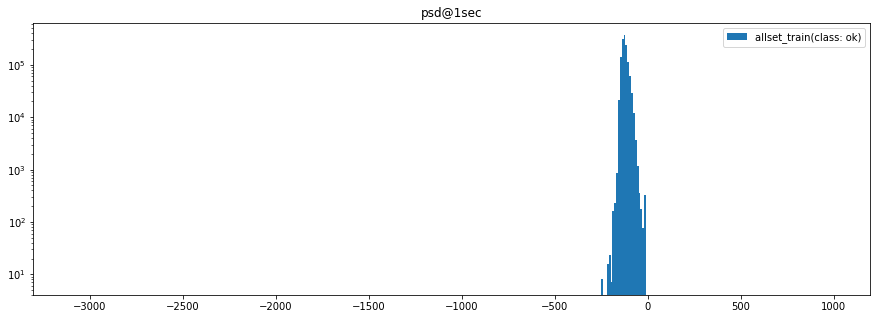

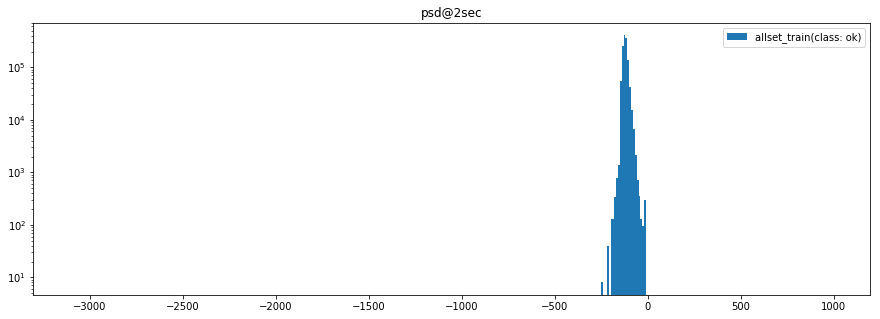

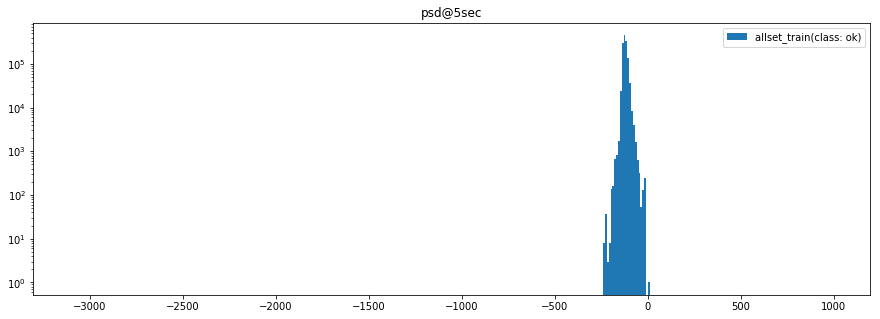

In [49]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
import sod.core.dataset as sod_dataset
importlib.reload(sod_dataset)
import matplotlib.pyplot as plt
import numpy as np

# matplotlib stuff (used below) =====================================
import matplotlib.pyplot as plt
from contextlib import contextmanager
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# =====================================================================
bins = np.arange(-3100, 1000, 10)

for caption, dataframe in [
    ('allset_test', allset_test),
    ('allset_train', allset_train),
    ]:
    dinfo = sod_dataset.dataset_info(dataframe)
    for col in ['psd@0.5sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@5sec']:
        # print('artifacts on ok segments: %d' % len(dataframe_ok[col<-3000]))

    # This prints the artifacts. Uncomment if you want to show them.
    # We inspected them and they are issued from a miniSeed with all constant (relatively high)
    # values. WHAT IS THE CAUSE?
    # dataframe_ok = dataframe[dinfo.class_selector[dinfo.classnames[0]](dataframe)]
    # dataframe_artifacts = dataframe_ok[col < -3000]
    # for (staid, did, segid), _ in dataframe_artifacts.groupby(['station_id', 'dataset_id', 'allset.id']):
    #     print('dataset id: %d, station id: %d, segment id: %d' % (did, staid, segid))
        data = []
        label = []
        for cname in dinfo.classnames:
            data.append(dataframe[dinfo.class_selector[cname](dataframe)][col])
            label.append(caption +  "(class: " + cname + ")")
        
        # bins = np.arange(int(np.nanmin(col)-10), int(np.nanmax(col)+10), 10)

        with plotparams({'figure.figsize': (15, 5)}):
            plt.hist(data, bins, log=True, histtype='bar', stacked=True, label=label)
            # print(_)
            # raise
            plt.title(col)
            plt.legend()
            plt.show()